# HCP Vector Pipeline

## Importing Native Files

In [1]:
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [2]:
import datetime
import dill
import matplotlib.pyplot as plt
import numpy as np
from optimization import SGD, GD1, GD2
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score

## Prepare HCP Data

In [3]:
#Load fMRI Resting State Data
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Print Shape of Data for Sanity
print(fmri_rs.shape)

#Take the Transpose so that each Sample is a Row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

(79800, 753)


In [4]:
#Create Train and Test Arrays corresponding to Training and Test Subjects
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape Labels into Column Vectors
X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Preprocessing Step

In [5]:
#Row Wise Normalization of Samples
def normalize_rows(matrix: np.ndarray):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    return normalized_matrix

#Preprocess Data
X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)

## Global Hyperparameters

In [6]:
use_bias = False
lamb = 0.19

## Closed Form Solver

Value of p^*: 893.8554852163037
-----------------------------Testing Error Metrics---------------------------------
NMSE: 0.13485415894185068
Correlation: 0.9409419085028259
R2_Score: 0.8188839647676105


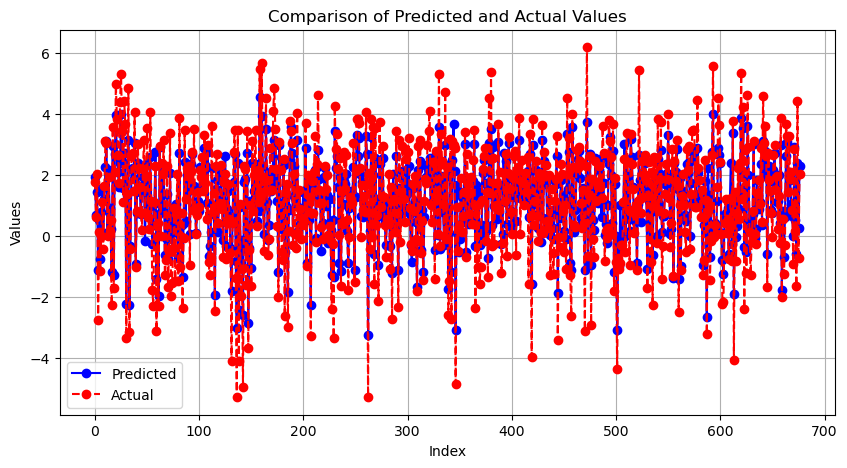

-----------------------------Testing Error Metrics---------------------------------
NMSE: 0.729350721526266
Correlation: 0.5008633955204339
R2_Score: 0.21808866080977785


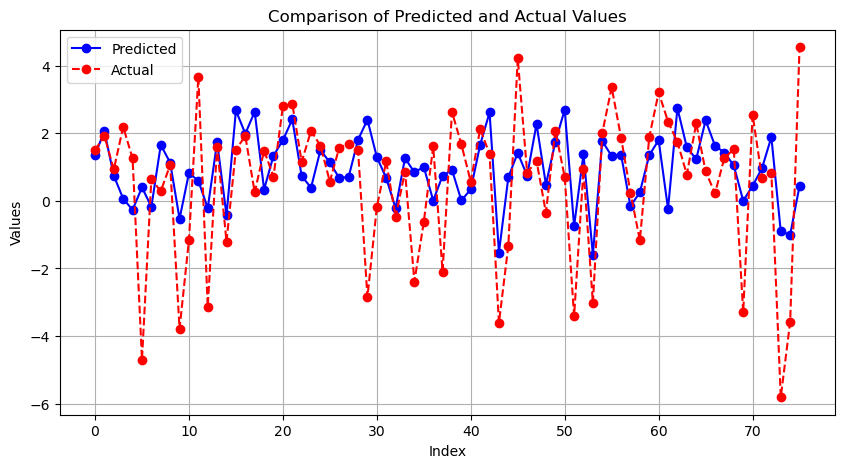

In [7]:
from sklearn.linear_model import Ridge

#Create Ridge Model with specific alpha value and fit to (X_train, Y_train)
model = Ridge(alpha = lamb, solver = 'svd', fit_intercept = use_bias)
model.fit(X_train, Y_train)

#Get Y_train predicted using model weights
Y_train_pred = model.predict(X_train).reshape((-1, 1))
weights = model.coef_.reshape((-1, 1))
W_true = weights

#Calculate Optimal Value
p_star = (np.linalg.norm(Y_train - Y_train_pred) ** 2) + (lamb * (np.linalg.norm(weights) ** 2))
print(f"Value of p^*: {p_star}")

#Compute Training Error Metrics
train_nmse_loss = np.sum(np.square((Y_train_pred - Y_train))) / np.sum(np.square(Y_train))
train_correlation = np.corrcoef(Y_train_pred.flatten(), Y_train.flatten())[0, 1]
train_R2_score = r2_score(Y_train, Y_train_pred)
error_metrics = [train_nmse_loss, train_correlation, train_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NMSE: {train_nmse_loss}")
print(f"Correlation: {train_correlation}")
print(f"R2_Score: {train_R2_score}")

# Plotting both arrays
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y_train_pred, label='Predicted', color='blue', marker='o')  # Plot Y_test_predicted
plt.plot(Y_train, label='Actual', color='red', linestyle='--', marker='o')  # Plot Y_test with dashed line
plt.title(f"Comparison of Predicted and Actual Values")  # Title of the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


Y_test_predicted =  model.predict(X_test).reshape((-1, 1))

#Compute Test Error Metrics
test_nmse_loss = np.sum(np.square((Y_test_predicted - Y_test))) / np.sum(np.square(Y_test))
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]
test_R2_score = r2_score(Y_test, Y_test_predicted)
error_metrics = [test_nmse_loss,test_correlation,test_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NMSE: {test_nmse_loss}")
print(f"Correlation: {test_correlation}")
print(f"R2_Score: {test_R2_score}")

# Plotting both arrays
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y_test_predicted, label='Predicted', color='blue', marker='o')  # Plot Y_test_predicted
plt.plot(Y_test, label='Actual', color='red', linestyle='--', marker='o')  # Plot Y_test with dashed line
plt.title(f"Comparison of Predicted and Actual Values")  # Title of the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot

## Gradient Descent[Exact Line Search] Solver

In [8]:
epochs = 1100
optimizer_code = 0

hypers = {'lambda': lamb, 'epochs': epochs, 'bias': use_bias}
W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values = GD2(X = X_train, Y = Y_train, cost_function_code = 1, hypers = hypers, p_star = p_star, W_true = W_true)

Value of t is: 0.0010755594862295937
Gradient Norm for linear.weight: 1287.072509765625
Epoch [1/1100], Loss: 2472.9556, Gap to Optimality: 1579.1001, NEE: 0.9964521753859716, NMSE: 0.734338641166687, Correlation: 0.26304781721860215, R2: 0.013745653130436297
Value of t is: 0.07107644254772336
Gradient Norm for linear.weight: 98.89896392822266
Epoch [2/1100], Loss: 2125.3562, Gap to Optimality: 1231.5007, NEE: 0.8238472092285011, NMSE: 0.6283157467842102, Correlation: 0.5019106222218298, R2: 0.1561398503602296
Value of t is: 0.0010933708819814867
Gradient Norm for linear.weight: 506.44805908203125
Epoch [3/1100], Loss: 1985.1366, Gap to Optimality: 1091.2811, NEE: 0.8216528669953002, NMSE: 0.5865675210952759, Correlation: 0.5068094848596795, R2: 0.21220987301805116
Value of t is: 0.03117876502697736
Gradient Norm for linear.weight: 75.68348693847656
Epoch [4/1100], Loss: 1895.8409, Gap to Optimality: 1001.9855, NEE: 0.7652615927389362, NMSE: 0.5587866902351379, Correlation: 0.633732020

## Stochastic Gradient Descent Solver

In [ ]:
lr = 0.001
epochs = 1100
batch_size = 128
use_bias = False
optimizer_code = 0

momentum = 0.9

hypers = {'lambda': lamb, 'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'bias': use_bias, 'optimizer_code': optimizer_code, 'momentum': momentum}
W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values = SGD(X = X_train, Y = Y_train, cost_function_code = 1, hypers = hypers, optimizer_code = optimizer_code, p_star = p_star, W_true = W_true)

In [ ]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
plt.title('Gap to Optimality')
plt.xlabel('Epoch')
plt.ylabel('Gap to Optimality')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(range(1, len(nee_values)+1), nee_values)
plt.title('NEE Values')
plt.xlabel('Epoch')
plt.ylabel('NEE')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(range(1, len(nmse_values)+1), nmse_values)
plt.title('NMSE Values')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(range(1, len(corr_values)+1), corr_values)
plt.title('Correlation Values')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(range(1, len(R2_values)+1), R2_values)
plt.title('R2 Values')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.grid(True)
plt.show()

In [ ]:
#Testing

weights = W_estimated
use_bias = b_estimated
Y_test_predicted = X_test @ W_estimated + use_bias

#Testing Accuracies

#Compute NEE, NMSE, Correlation, and R^2 Score
test_normalized_estimation_error = ((np.linalg.norm(W_estimated - W_true)) ** 2) /  ((np.linalg.norm(W_true)) ** 2)
test_nmse_loss = np.sum(np.square((Y_test_predicted - Y_test))) / np.sum(np.square(Y_test))
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]
test_R2_score = r2_score(Y_test, Y_test_predicted)

error_metrics = [test_normalized_estimation_error,test_nmse_loss,test_correlation,test_R2_score]

print('-----------------------------Testing Error Metrics---------------------------------')
print(f"NEE: {test_normalized_estimation_error}")
print(f"NMSE: {test_nmse_loss}")
print(f"Correlation: {test_correlation}")
print(f"R2_Score: {test_R2_score}")
print(f"Bias: {use_bias}")

# Plotting both arrays
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y_test_predicted, label='Predicted', color='blue', marker='o')  # Plot Y_test_predicted
plt.plot(Y_test, label='Actual', color='red', linestyle='--', marker='o')  # Plot Y_test with dashed line
plt.title(f"Comparison of Predicted and Actual Values")  # Title of the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pkl_file = f"../Experimental Results/"
for param in hypers:
   pkl_file += f"{param}={hypers[param]}."

pkl_file += ".pkl"

with open(pkl_file, "wb") as file:
   dill.dump((p_star, lamb, error_metrics, W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values), file)



